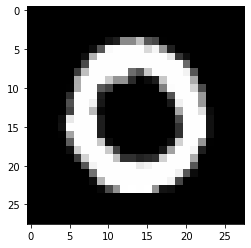

In [1]:
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

seed = 15
np.random.seed(seed)  
torch.manual_seed(seed)

trainfile = '/kaggle/input/digit-recognizer/train.csv'
trainfile=pd.read_csv(trainfile)

trainfile_x = trainfile.iloc[:,1:].values.astype('float32')
trainfile_y = trainfile.iloc[:,0]

# csvファイルを読み込み、28x28ピクセルの画像データに変換する関数
def load_mnist_data(file_x):
    data = file_x
    images = []
    for i in range(len(data)):
        pixels = data[i][:].reshape((28, 28))
        images.append(pixels)
    return images

# 画像データを表示する関数
def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.show()

mnist_data = load_mnist_data(trainfile_x)

show_image(mnist_data[1])

In [2]:
train_label = trainfile_y.to_numpy()
train_data = np.array(mnist_data)

# 元のデータをトレーニング用と検証用に分ける
divide_num = int(len(train_label)*0.8)
validation_label = train_label[divide_num:]
train_label = train_label[:divide_num]
 
validation_data = train_data[divide_num:]
train_data = train_data[:divide_num]

In [3]:
class DataSet:
    def __init__(self, data, label):
        self.X = data # 入力
        self.t = label #出力
        
    def __len__(self):
        return len(self.X) # データ数を返す

    def __getitem__(self, index):
        # index番目の入出力ペアを返す
        return self.X[index], self.t[index]

In [4]:
# numpyの型からPyTorchの型に変換
train_data = torch.from_numpy(train_data).float().unsqueeze(1)
train_label = torch.from_numpy(train_label).long()
validation_data = torch.from_numpy(validation_data).float().unsqueeze(1)
validation_label = torch.from_numpy(validation_label).long()

In [5]:
# バッチサイズの指定
batch_size = 64

train_dataset = DataSet(train_data, train_label)
validation_dataset = DataSet(validation_data, validation_label)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [6]:
train_data.shape

torch.Size([33600, 1, 28, 28])

In [7]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.7 MB/s eta 0:00:00


In [8]:
class Conv_bn(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation=0):
        super(Conv_bn, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(num_features=out_channels)

    def forward(self, x):
        y = self.bn(self.conv(x))
        return y

In [9]:
class FReLU(nn.Module):
    def __init__(self, in_c, k=3, s=1, p=1):
        super().__init__()
        self.f_cond = nn.Conv2d(in_c, in_c, kernel_size=k,stride=s, padding=p, groups=in_c)
        self.bn = nn.BatchNorm2d(in_c)

    def forward(self, x):
        tx = self.bn(self.f_cond(x))
        out = torch.max(x,tx)
        return out

# CNNモデルを定義する
class Net(nn.Module):
    def __init__(self, in_ch=1, n_class=10, c1=16, c2=32, c_l=192, c_f=64):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
                            Conv_bn(in_channels=in_ch, out_channels=c1, kernel_size=5, stride=1, padding=2),
                            FReLU(c1),
                            Conv_bn(in_channels=c1, out_channels=c1, kernel_size=5, stride=1, padding=2),
                            FReLU(c1),
                        )
        self.layer2 = nn.Sequential(
                            Conv_bn(in_channels=c2, out_channels=c2, kernel_size=5, stride=2, padding=2),
                            FReLU(c2),
                            Conv_bn(in_channels=c2, out_channels=c2, kernel_size=5, stride=1, padding=2),
                            FReLU(c2),
                            nn.MaxPool2d(2, 2),
                        )
        self.large = nn.Sequential(
                            Conv_bn(in_channels=in_ch, out_channels=c1, kernel_size=5, stride=1, padding=2),
                            nn.ReLU(),
                        )
        
        self.frelu2 = FReLU(c2)
        self.fc1 = nn.Linear(c2 * 7 * 7, c_l)
        self.fc2 = nn.Linear(c_l, c_f)
        self.fc3 = nn.Linear(c_f, n_class)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.1)

    def forward(self, x):
        large = self.large(x)
        x = self.layer1(x)
        x = self.layer2(torch.cat([x, large], dim=1))
        x = x.view(x.size()[0], 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [10]:
import time
from torchvision import transforms

# エポック数
num_epochs = 50

# 初期学習率
initial_lr = 0.01

# GPU使用を試みる
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:',device,'\n')
# 辞書にまとめる
dataloaders_dict = {
    'train': train_dataloader, 
    'valid': validation_dataloader
}

PATH ="model.pth"
best_val = 0

net = Net()
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=initial_lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15,25,35], gamma=0.7)

time_start = time.time()
transform = transforms.Compose([
    transforms.Normalize(33.41, 78.67),
])

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    print('-------------')
    
    for phase in ['train', 'valid']:
        if phase == 'train':
            net.train()
        else:
            net.eval()
            
        epoch_loss = 0.0
        epoch_corrects = 0
        
        for inputs, labels in dataloaders_dict[phase]:
            inputs = transform(inputs.to(device))
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == 'train'):
                
                outputs = net(inputs)
                
                loss = criterion(outputs, labels)
                
                _, preds = torch.max(outputs, 1)
                
                if phase == 'train':
                    loss.backward()
                    
                    optimizer.step()
                    scheduler.step()
                    
                epoch_loss += loss.item() * inputs.size(0)
                
                epoch_corrects += torch.sum(preds == labels.data)

        epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
        epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        if phase == 'valid' and epoch_acc >= best_val:
            print("best val!!")
            best_val = epoch_acc
            torch.save(net.state_dict(), PATH)
            
time_end = time.time()
print('\nElapsed time: {:.3f} sec'.format(time_end - time_start))

device: cuda:0 

Epoch 1/50
-------------
train Loss: 1.3602 Acc: 0.6484
valid Loss: 0.4366 Acc: 0.9280
best val!!
Epoch 2/50
-------------
train Loss: 0.3510 Acc: 0.9159
valid Loss: 0.1550 Acc: 0.9674
best val!!
Epoch 3/50
-------------
train Loss: 0.1891 Acc: 0.9500
valid Loss: 0.1045 Acc: 0.9740
best val!!
Epoch 4/50
-------------
train Loss: 0.1412 Acc: 0.9614
valid Loss: 0.0816 Acc: 0.9786
best val!!
Epoch 5/50
-------------
train Loss: 0.1125 Acc: 0.9689
valid Loss: 0.0684 Acc: 0.9793
best val!!
Epoch 6/50
-------------
train Loss: 0.0944 Acc: 0.9743
valid Loss: 0.0634 Acc: 0.9812
best val!!
Epoch 7/50
-------------
train Loss: 0.0832 Acc: 0.9764
valid Loss: 0.0565 Acc: 0.9825
best val!!
Epoch 8/50
-------------
train Loss: 0.0732 Acc: 0.9799
valid Loss: 0.0499 Acc: 0.9845
best val!!
Epoch 9/50
-------------
train Loss: 0.0669 Acc: 0.9819
valid Loss: 0.0482 Acc: 0.9845
best val!!
Epoch 10/50
-------------
train Loss: 0.0615 Acc: 0.9829
valid Loss: 0.0475 Acc: 0.9843
Epoch 11/50
-

In [11]:
testfile = '/kaggle/input/digit-recognizer/test.csv'

testfile=pd.read_csv(testfile)
testfile

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
testfile_x = testfile.values.astype('float32')
test_data = load_mnist_data(testfile_x)
test_data = np.array(test_data)
test_dataset = torch.from_numpy(test_data).float().unsqueeze(1).cuda(device)

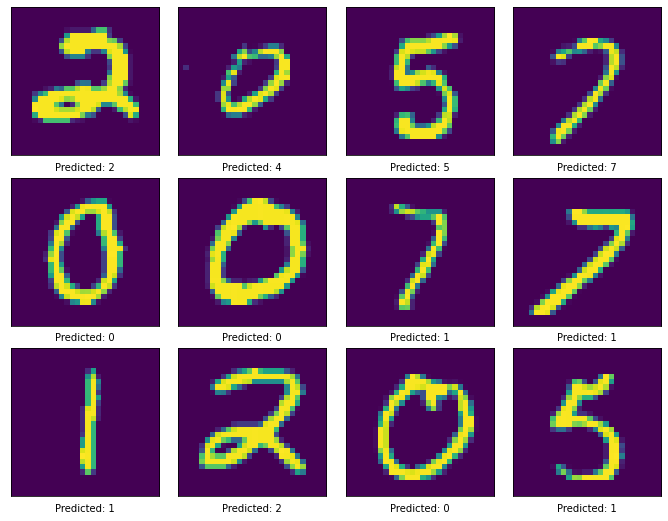

In [13]:
# いくつかのテストデータを推定して表示
px = 4
py = 3

iselect =[ 0, 3, 10, 11, 
          100, 111, 113, 115,
          200, 220, 230, 277]  # 選ぶ画像を指示

selected_data = test_dataset[iselect]
net.load_state_dict(torch.load(PATH))
with torch.no_grad():
    outputs = net(selected_data)
    _, predicted = torch.max(outputs.data, 1)

fig, ax = plt.subplots(py, px, figsize=(12, 9))
fig.subplots_adjust(hspace=0.15, wspace=0)

for i in range(py):
    for j in range(px):
        imgdata = test_data[iselect[i*px+j]]
        img = imgdata.reshape(28,28)
        ax[i, j].xaxis.set_major_locator(plt.NullLocator())
        ax[i, j].yaxis.set_major_locator(plt.NullLocator())
        ax[i, j].set_xlabel('Predicted: '+ str(predicted[i*px+j].item()))
        ax[i, j].imshow(img)

plt.show()

In [14]:
subfile = '/kaggle/input/digit-recognizer/sample_submission.csv'
submission = pd.read_csv(subfile)

with torch.no_grad():
    outputs = net(transform(test_dataset))
    _, predicted = torch.max(outputs.data, 1)
    
for i in range(len(testfile_x)):
    submission["Label"][i] = predicted[i].item()
    

submission.to_csv("submission.csv", index=False)

In [15]:
submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
